In [1]:
#import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier,export_graphviz
import graphviz
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict, KFold

### A toy 2-d data set for decision tree and boosting

##### a)

In [2]:
data = np.genfromtxt('data3.txt')

x = data[:, :2]
y = data[:, 2]

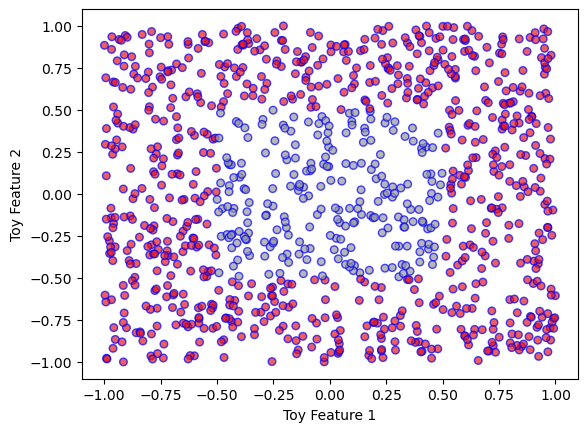

In [3]:
plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.Set1, edgecolor='b', alpha=0.7, s=30)
plt.xlabel('Toy Feature 1')
plt.ylabel('Toy Feature 2')
plt.show()

##### b)

In [4]:
clf = DecisionTreeClassifier()
clf.fit(x, y)

print(clf.tree_)

The stopping criterion is when all leaf nodes are pure. In this case, the algorithm would continue to split nodes until it achieves a pure split for all the features in the dataset. At this point, the algorithm would stop growing the tree further, and each leaf node would represent a specific combination of features that can be used for classification.

##### c)

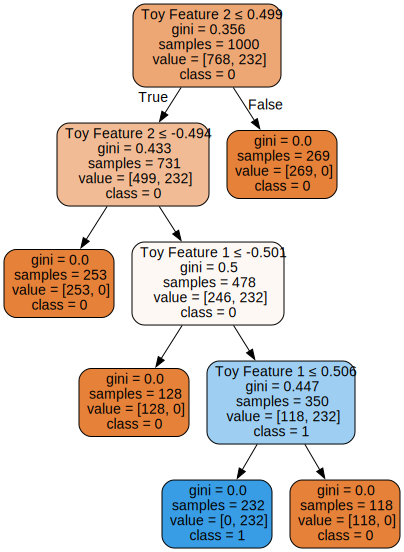

In [5]:
# Export the decision tree to DOT format
dot_data = export_graphviz(clf, out_file=None, 
                           feature_names=['Toy Feature 1', 'Toy Feature 2'],  
                           class_names=['0', '1'],  
                           filled=True, rounded=True,  
                           special_characters=True)  
# Visualize the decision tree
graph = graphviz.Source(dot_data)  
graph

##### d)

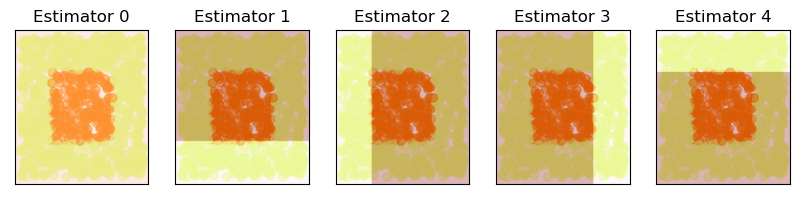

In [6]:
# Fit an AdaBoostClassifier with decision stumps
num_estimators = 5  # Set the number of decision stumps
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=num_estimators)
clf.fit(x, y)

# Display each of the decision stumps
fig, axes = plt.subplots(nrows=1, ncols=num_estimators, figsize=(10, 2), dpi=100)
for i, estimator in enumerate(clf.estimators_):
    axes[i].scatter(x[:, 0], x[:, 1], c=y, cmap='Wistia', alpha=0.5)
    plot_step = 0.02
    x_min, x_max = x[:, 0].min() - 0.1, x[:, 0].max() + 0.1
    y_min, y_max = x[:, 1].min() - 0.1, x[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step))
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axes[i].contourf(xx, yy, Z, cmap=plt.cm.Reds, alpha=0.3)
    axes[i].set_xticks(())
    axes[i].set_yticks(())
    axes[i].set_title('Estimator %d' % i)
plt.show()

##### e)

In [7]:
# Print a table of the training accuracy after each iteration
print("Number of Stumps\tTraining Accuracy")
print("---------------\t-----------------")
for i, y_pred in enumerate(clf.staged_predict(x)):
    acc = (y_pred == y).mean()
    print(f"\t{i+1}\t\t{acc:.2f}")

Number of Stumps	Training Accuracy
---------------	-----------------
	1		0.77
	2		0.77
	3		0.88
	4		1.00
	5		1.00


### Credit Card Fraud Data

##### a)

In [8]:
df = pd.read_csv('creditcard.csv')

# Count the number of fraudulent transactions
num_fraudulent = len(df[df['Class'] == 1])

# Print the number of fraudulent transactions
print("Number of fraudulent transactions: ", num_fraudulent)

Number of fraudulent transactions:  492


##### b)

In [9]:
# Separate the fraudulent and legitimate transactions
fraudulent = df[df['Class'] == 1]
legitimate = df[df['Class'] == 0]

# Downsample the legitimate transactions to match the number of fraudulent transactions
downsampled = resample(legitimate, 
                       replace=False, # sample without replacement
                       n_samples=len(fraudulent)) # match number of fraudulent samples

# Combine the fraudulent and downsampled legitimate transactions into a single dataframe
balanced = pd.concat([fraudulent, downsampled])

# Shuffle the rows in the dataframe
balanced = balanced.sample(frac=1)

##### c)

In [10]:
# Define the classifiers
dtc = DecisionTreeClassifier()
abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1))
rfc = RandomForestClassifier()

# Define the number of folds for cross-validation
n_splits = 5
# Define the cross-validation method
kf = KFold(n_splits=n_splits, shuffle=True)


# Define the confusion matrices
cm_dtc = np.zeros((2, 2))
cm_abc = np.zeros((2, 2))
cm_rfc = np.zeros((2, 2))

# Perform cross-validation and compute confusion matrices
for train_index, test_index in kf.split(x):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    dtc.fit(X_train, y_train)
    y_pred_dtc = dtc.predict(X_test)
    cm_dtc += confusion_matrix(y_test, y_pred_dtc)
    
    abc.fit(X_train, y_train)
    y_pred_abc = abc.predict(X_test)
    cm_abc += confusion_matrix(y_test, y_pred_abc)
    
    rfc.fit(X_train, y_train)
    y_pred_rfc = rfc.predict(X_test)
    cm_rfc += confusion_matrix(y_test, y_pred_rfc)

# Compute the average confusion matrix for each classifier
cm_dtc /= n_splits
cm_abc /= n_splits
cm_rfc /= n_splits

# Print the confusion matrices
print('Decision Tree Confusion Matrix:')
print(cm_dtc)
print()
print('Boosted Decision Stumps Confusion Matrix:')
print(cm_abc)
print()
print('Random Forest Confusion Matrix:')
print(cm_rfc)

Decision Tree Confusion Matrix:
[[153.6   0. ]
 [  1.2  45.2]]

Boosted Decision Stumps Confusion Matrix:
[[153.6   0. ]
 [  0.6  45.8]]

Random Forest Confusion Matrix:
[[153.6   0. ]
 [  1.   45.4]]
